<img src="images/seemapldbig.png">

# Let's Continue Our Machine Learning Journey With Transfer Learning In Computer Vision In Pytorch.
# In This Notebook You Will:
### &emsp;- Learn Some Basics About Transfer Learning And Fine-Tuning
### &emsp;- Write And Run Some Pytorch Code
### &emsp;- Leverage the "Data/Train/Evaluate" Pipeline
### &emsp;- Deploy The Model To The Edge ( Jetson NANO )

# First, Let's Discuss Why Transfer Learning Is Important...

### &emsp;- Training Models From Scratch Is Often Not Necessary

### &emsp;- Many Pre-Trained Base Or "Foundation" Models Exist And Can Be "Fine-Tuned" On Your Data

### &emsp;- Fine-Tuning Will Take Fewer Resources And Can Address Data Transport Concerns

# Why Pytorch?

### &emsp;- The most popular ML framework 

### &emsp;- Deep Traction In Industry and Academia

### &emsp;- All Research Papers Worth Considering Publish Code In Pytorch 

# We Will Use the Pipeline You Are Already Familiar With...<img src="images/clean_pipeline.png">

# Let's Go Through The Specific Python Packages We Will Need In This Notebook...

In [1]:
#
# Import python packages
#

# useful system and "builtin" packages
import time
import os
import copy

# math and data science related
import numpy as np
import matplotlib.pyplot as plt

# pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms


# Load A Dataset In Pytorch...
<img src="images/all-data-pipeline.png">

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# If Possible, Always Visualize Your Data Before You Train...

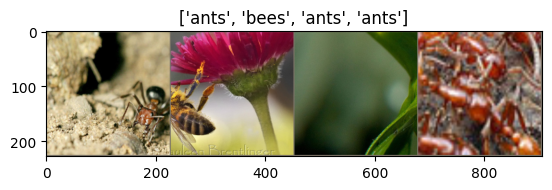

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Fine-Tune A Model In Pytorch...
<img src="images/all-train-pipeline.png">

In [5]:
#
# Here we are choosing a pre-trained model and
# setting up training parameters.
#

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to("cpu")

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
#
# Here we are defining our training loop
#

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to("cpu")
                labels = labels.to("cpu")

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
#
# Now lets fine-tune it on the data!
#

if os.path.exists("data/seemap2023_ft.pt"):
    print("Found model, loading...")
    model_ft = torch.load("data/seemap2023_ft.pt")
    
else:
    print("Fine tuning model...")
    print("Start time=", time.time())
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
    torch.save(model_ft, "data/seemap2023_ft.pt")
    print("End time=", time.time())

Fine tuning model...
Start time= 1683483077.451762
Epoch 0/24
----------
train Loss: 0.6160 Acc: 0.6926
val Loss: 0.2384 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.6320 Acc: 0.7664
val Loss: 0.9947 Acc: 0.7451

Epoch 2/24
----------
train Loss: 0.5499 Acc: 0.7787
val Loss: 0.3919 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.8399 Acc: 0.7377
val Loss: 0.2680 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.6429 Acc: 0.7541
val Loss: 0.3884 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.6467 Acc: 0.7213
val Loss: 0.2893 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4706 Acc: 0.7992
val Loss: 0.3902 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4977 Acc: 0.7992
val Loss: 0.3267 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3386 Acc: 0.8566
val Loss: 0.3327 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.3729 Acc: 0.8320
val Loss: 0.3151 Acc: 0.8758

Epoch 10/24
----------
train Loss: 0.4097 Acc: 0.8074
val Loss: 0.2922 Acc: 0.9020

Epoch 11/24
----------
train Loss: 

# Evaluate The Fine-Tuned Model In Pytorch...
<img src="images/eval-model.png">

In [11]:
#
# Define a function which evaluates the model on randomly chosen
# data from the test set.
#

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to("cpu")
            labels = labels.to("cpu")

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

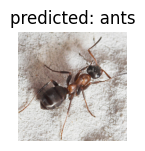

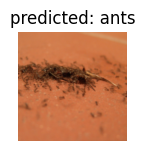

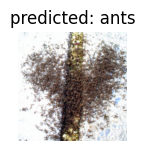

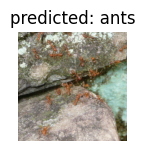

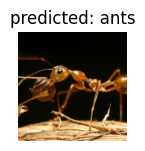

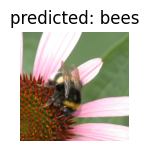

In [12]:
visualize_model(model_ft)

plt.ioff()
plt.show()

# Now Let's Deploy The Trained Model To Your NVidia Jetson NANO...

<img src="images/nano.jpg">